## It allows your to evaluate fluid flow distribution in a multi-fractured doublet (EGS) Enhanced Geothermal System model.

In [1]:
import numpy as np  #Importing NumPy
import math 

In [2]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [3]:
#Calculate fracture permeabilities
import random
def FracturePermeability(n,Kb,FractureWidth,FractureHeight,premact):
    Kf=np.zeros(n)
    for i in range(n):
        if premact==0:
            Kf[i]=Kb
        else:
            rndnum=(random.uniform(1, 10))
            rndnum1=(random.choice([-1, 0, 1]))  #Magnitude
            Kf[i]=rndnum*Kb*(10**rndnum1)
    return Kf

In [4]:
#Adaptive Perforations
def AdaptivePerforation(WellsOrientation,VariablePermeability,AdaptivePerf,NumberOfFractures,Diameter_Perforation,BaseDiameter_Perforation,Permeability_Fracture):
    GMean = math.prod(Permeability_Fracture)**(1/len(Permeability_Fracture))
    if WellsOrientation==1 or WellsOrientation==3:
        for i in range(NumberOfFractures):
            if VariablePermeability==0:
                if AdaptivePerf==1:
                    #Diameter_Perforation[i]=BaseDiameter_Perforation*(1.3**(math.log(GMean/Permeability_Fracture[i],10)))
                    Diameter_Perforation[i]=((i+2)**0.4/NumberOfFractures**0.3)*BaseDiameter_Perforation
                else:
                    Diameter_Perforation[i]=BaseDiameter_Perforation
            else:
                if AdaptivePerf==1:
                    Diameter_Perforation[i]=BaseDiameter_Perforation*(1.3**(math.log(GMean/Permeability_Fracture[i],10)))
                else:
                    Diameter_Perforation[i]=BaseDiameter_Perforation
    elif WellsOrientation==2:
        if NumberOfFractures%2==0:
            for i in range(int(NumberOfFractures/2)):
                if VariablePermeability==0:
                    if AdaptivePerf==1:
                        Diameter_Perforation[i]=((i+2)**0.4/NumberOfFractures**0.3)*BaseDiameter_Perforation
                    else:
                        Diameter_Perforation[i]=BaseDiameter_Perforation
                    Diameter_Perforation[int(NumberOfFractures-1)-i]=Diameter_Perforation[i]
                else:
                    if AdaptivePerf==1:
                        Diameter_Perforation[i]=BaseDiameter_Perforation*(1.3**(math.log(GMean/Permeability_Fracture[i],10)))
                    else:
                        Diameter_Perforation[i]=BaseDiameter_Perforation        
        else:
            for i in range(int((NumberOfFractures+1)/2)):
                if VariablePermeability==0:
                    if AdaptivePerf==1:
                        Diameter_Perforation[i]=((i+2)**0.4/NumberOfFractures**0.3)*BaseDiameter_Perforation
                    else:
                        Diameter_Perforation[i]=BaseDiameter_Perforation
                    if i!=int((NumberOfFractures-1)/2):
                        Diameter_Perforation[int(NumberOfFractures-1)-i]=Diameter_Perforation[i]
                else:
                    if AdaptivePerf==1:
                        Diameter_Perforation[i]=BaseDiameter_Perforation*(1.3**(math.log(GMean/Permeability_Fracture[i],10)))
                    else:
                        Diameter_Perforation[i]=BaseDiameter_Perforation
    return Diameter_Perforation

In [5]:
#Reynolds Number
def Rep(q,D):
    re=1000*(q/(math.pi*D**2*0.25))*D/(8.91e-4)
    return re

In [6]:
#Colebrook–White equation
def cole(f,e,D,Rep):
    resid=(1/f**0.5)+2*math.log10((e/(3.7*D))+2.51/(Rep*f**0.5))
    return resid

In [7]:
#Pressure Drop in Pipe
def Fhal(e,D,Rep):
    if Rep<=4000: #Haaland’s equation
        f=1/(-1.8*math.log10(((e/D)/3.7)**1.1+(6.9/Rep)))**2
    else:  #Colebrook–White equation
        f=fsolve(cole,0.01,args=(e,D,Rep),xtol=1e-10)
    return f

In [8]:
#Fanning friction factor
def Ffan(Rep):
    f=16/Rep
    return f

In [9]:
#Pressure drop in Frac
#P. A. WITHERSPOON #Validity of Cubic Law for Fluid Flow in a Deformable Rock Fracture 
def Pfrac(q,L,W,af,ff):
    Pfrac=12*8.91e-4*q*L*ff/(W*af**3)
    return Pfrac

In [10]:
#Flow rate in Fracs with Darcy and all Perforations
def temp1(Qfrac,Pfrac,L,A,k,Cd,Np,DPinj,DPpro):
    resid=Pfrac-(Qfrac*L*8.91e-4/(k*A))-(Qfrac**2*1000*0.808060652/((Cd**2)*(Np**2)*(DPinj**4)))-(Qfrac**2*1000*0.808060652/((Cd**2)*(Np**2)*(DPpro**4)))
    return resid
def Q_all_perfs(Pfrac,L,A,k,Cd,Np,DPinj,DPpro):
    Qfrac=fsolve(temp1,0.01,args=(Pfrac,L,A,k,Cd,Np,DPinj,DPpro),xtol=1e-10)
    return Qfrac

In [11]:
#Flow rate in Fracs with Darcy and only Injection Perforations
def temp2(Qfrac,Pfrac,L,A,k,Cd,Np,DPinj):
    resid=Pfrac-(Qfrac*L*8.91e-4/(k*A))-(Qfrac**2*1000*0.808060652/((Cd**2)*(Np**2)*(DPinj**4)))
    return resid
def Q_Injection_perfs(Pfrac,L,A,k,Cd,Np,DPinj):
    Qfrac=fsolve(temp2,0.01,args=(Pfrac,L,A,k,Cd,Np,DPinj),xtol=1e-10)
    return Qfrac

In [12]:
#Flow rate in Fracs with Darcy and only Production Perforations
def temp3(Qfrac,Pfrac,L,A,k,Cd,Np,DPpro):
    resid=Pfrac-(Qfrac*L*8.91e-4/(k*A))-(Qfrac**2*1000*0.808060652/((Cd**2)*(Np**2)*(DPpro**4)))
    return resid
def Q_Production_perfs(Pfrac,L,A,k,Cd,Np,DPpro):
    Qfrac=fsolve(temp3,0.01,args=(Pfrac,L,A,k,Cd,Np,DPpro),xtol=1e-10)
    return Qfrac

In [13]:
#Flow rate in Fracs with Darcy and no Perforations
def temp4(Qfrac,Pfrac,L,A,k):
    resid=Pfrac-(Qfrac*L*8.91e-4/(k*A))-(Qfrac**2*1000*0.808060652)-(Qfrac**2*1000*0.808060652)
    return resid
def Q_No_perfs(Pfrac,L,A,k):
    Qfrac=fsolve(temp4,0.01,args=(Pfrac,L,A,k),xtol=1e-10)
    return Qfrac

In [14]:
#Pressure drop in Frac Darcy
#Darcy's Law
def Pfdarcy(q,L,A,k):
    Pfrac=q*8.91e-4*L/(k*A)
    return Pfrac

In [15]:
#Flow rate in Fracs Darcy
#Darcy's Law
def Qfdarcy(Pfrac,L,A,k):
    q=Pfrac*k*A/(L*8.91e-4)
    return q

In [16]:
#Pressure drop in Perforations
#Weddle and Cramer
def Pperf(q,Cd,Np,Dp):
    Pperf=0.808060652*(q**2)*1000/((Cd**2)*(Np**2)*(Dp**4))
    return Pperf

In [17]:
#Pressure plots
def pplots(P,n,name,save,path):
    distpct=np.empty(n)
    temp=np.empty(n)
    plt.figure(figsize = (8,5))
    pmin=min(P)
    pmax=max(P)
    plt.ylim(ymin=pmin*0.95)
    plt.ylim(ymax=pmax*1.05)
    if name=="Width":
        plt.ylim(ymin=pmin*0.90*1000)
        plt.ylim(ymax=pmax*1.1*1000)
    # set width of bar
    barWidth = 1*(n-1)/(n+1)

    for i in range(0,n):
        distpct[i]=P[i]
        if name=="Width":
            distpct[i]=P[i]*1000
    x = np.linspace(1, n, n)
    plt.bar(x,distpct,width=barWidth,zorder=2,color='teal')
    # Add xticks on the middle of the group bars
    plt.xticks(np.arange(1, n+1, step=1))
    plt.xlabel('Fracture Number', fontweight='bold',fontsize=14)
    plt.ylabel('Pressure (Pa)', fontweight='bold',fontsize=14)
    plt.title('\n%s Pressure Distribution in Fractures' %name, fontweight='bold',fontsize=18)
    if name=="Permeability":
        plt.yscale('log')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.title('\n%s Distribution in Fractures' %name, fontweight='bold',fontsize=18)
        plt.ylabel('Permeability m2', fontweight='bold',fontsize=14)
        plt.hlines(math.prod(P)**(1/len(P)), 0, n+1, colors='r', linestyles='solid',zorder=3)  
    #plt.legend(loc="upper center",ncol=3,bbox_to_anchor= (0.5, -0.15),prop={'size': 12},frameon=True)
    plt.grid(which='major', axis='both',color='lightgrey',zorder=1)
    if save=="yes":
        plt.savefig(r'%s/%s.png' %(path,name), bbox_inches='tight')
    return plt.show()

In [18]:
#For Fracture
NumberOfFractures=10
TotalWellLength=1000 #m, Length of the well
BasePermeability=1e-12 #m2, #Fracture base Permebility
FractureHeight=100 #m Fracture entrance length
FractureWidth=5.0 #m Fracture entrance pseudo width
BaseFractureLength=100 #m Height of fractures
Area_FractureEntrance=FractureHeight*FractureWidth #Area of fracture for the fluid to enter

#For Pipe
Diameter_InjectionWell=0.1524#*(0.5/0.1524)   #m Diameter of the Injection Pipe
Diameter_ProductionWell=0.1524#*(0.5/0.1524)  #m Diameter of the Production Pipe
Area_InjectionWell=math.pi*Diameter_InjectionWell**2*0.25 #meters sq.
Area_ProductionWell=math.pi*Diameter_InjectionWell**2*0.25 #meters sq.
DensityWater=1000 #kg/s
e=0.015/1000  #roughness in m
BaseInjectionWellSection=TotalWellLength/NumberOfFractures #m Length of Inj pipe section
BaseProductionWellSection=TotalWellLength/NumberOfFractures #m Length of Prod pipe section

#For Perforation
LengthOfPerfZone=1 #m, length og each perf zone
Cd=0.75 #Discharge Coefficient
NumberOfPerfPerMeter=10 # Number of perforations per meter
NumberOfPerfs=LengthOfPerfZone*NumberOfPerfPerMeter #Number of Perforations
BaseDiameter_InjectionPerforation=0.003175*3#*0.5 #m, Diameter of perforations
BaseDiameter_ProductionPerforation=0.003175*3#*0.5 #m, Diameter of perforations

In [19]:
#Initialization
Pressure_Injection=np.zeros(NumberOfFractures+1)
Pressure_Production=np.zeros(NumberOfFractures+1)
Pressure_Fracture=np.zeros(NumberOfFractures)
Flowrate_Fracture=np.zeros(NumberOfFractures)
FractureLength=np.zeros(NumberOfFractures)
InjectionWellSection=np.zeros(NumberOfFractures+1)
ProductionWellSection=np.zeros(NumberOfFractures+1)
Permeability_Fracture=np.zeros(NumberOfFractures)
Diameter_InjectionPerforation=np.zeros(NumberOfFractures)
Diameter_ProductionPerforation=np.zeros(NumberOfFractures)
WellAngle=0

In [20]:
#Flow Rate and Pressure
Flowrate_Initial=50 #kg/s
Pressure_Injection[0]=3e7

In [21]:
#Turn on pressure drop in injection well
InjectionWellActivate=1 #if 1, the pressure drop in the well is on
#Turn on pressure drop in production well
ProductionWellActivate=1 #if 1, the pressure drop in the well is on
#Activate Perforation
ActivateInjectionPerforations=1  #If 0, perforation pressure drop is zero.
#activate production well perforation
ActivateProductionPerforations=1

#Variable Permeablity
# If 0, All fractures have same permeability
# If 1, The permeability values are assigned at random with respect to the base value
# If 2, Option to input custom permeability values.
VariablePermeability=0


#ORIENTATION OF WELLS
# If 1, The wells are Parallel
# If 2, The wells are Anti-Parallel
# If 3, The wells are Non-Parallel  # Input the Difference between first and last fracture
WellsOrientation=2

if WellsOrientation==3:
    d1=float(input("Enter the difference between the first and last fracture size: "))
    BaseFractureLength=BaseFractureLength-d1/2
    WellAngle=math.atan((d1/2)/((NumberOfFractures-1)*BaseInjectionWellSection)) #Angle of Injection well
    print(math.degrees(WellAngle)*2)
for i in range(NumberOfFractures):
    Flowrate_Fracture[i]=Flowrate_Initial/NumberOfFractures
    FractureLength[i]=abs(BaseFractureLength+(NumberOfFractures-i-1)*math.tan(WellAngle)*BaseInjectionWellSection+(NumberOfFractures-i-1)*math.tan(WellAngle)*BaseProductionWellSection)
for i in range(NumberOfFractures+1):
    InjectionWellSection[i]=BaseInjectionWellSection/math.cos(WellAngle)
    ProductionWellSection[i]=BaseProductionWellSection/math.cos(WellAngle)

#Adaptive Perforation (Still in test phase)
# If 0, Adaptive Perforations are turned off
# If 1, Adaptive Perforations are turned on
# If 2, Custom input for Perforations
AdaptivePerf=1

In [22]:
#Calculate Fracture Permeability
#Function is defined as:
# var1*BasePermeability*(10^var2), where Var1 varies from 1 to 10 and Var2 varies from -1, 0 or 1, at random.
if VariablePermeability!=2:
    Permeability_Fracture=FracturePermeability(NumberOfFractures,BasePermeability,FractureWidth,FractureHeight,VariablePermeability)
else:
    for i in range(NumberOfFractures):
        #Define any custom function
        if i%2==0:
            Permeability_Fracture[i]=BasePermeability/2
        else:
            Permeability_Fracture[i]=BasePermeability

In [26]:
#Define a custom fucntion for Perforation diameters
if AdaptivePerf==2:
    for i in range(NumberOfFractures):
        #Define any custom function
        Diameter_InjectionPerforation[i]=BaseDiameter_InjectionPerforation*0.9
        Diameter_ProductionPerforation[i]=BaseDiameter_InjectionPerforation*0.8

In [35]:
MaxIterations=1000 #number of iterations
#mmax=10000 #max number of iterations
Tolerance=1e-6 #Tolerance
Flowrate_Update=np.zeros(NumberOfFractures)
Flowrate_Frac1=np.zeros(MaxIterations)
Flowrate_Frac5=np.zeros(MaxIterations)

for j in range(MaxIterations):
    Flowrate_Cumulative=Flowrate_Initial/1000
    #pressure drop in injection well
    for i in range(NumberOfFractures):
        if InjectionWellActivate==0:
            Pressure_Injection[i+1]=Pressure_Injection[i]
        else:            
            Pressure_Injection[i+1]=Pressure_Injection[i]-Fhal(e,Diameter_InjectionWell,Rep(Flowrate_Cumulative,Diameter_InjectionWell))*2*InjectionWellSection[i+1]*DensityWater*(Flowrate_Cumulative/Area_InjectionWell)**2/Diameter_InjectionWell
        Flowrate_Cumulative=Flowrate_Cumulative-Flowrate_Fracture[i]/1000

    #Pressure drop in Production well
    Flowrate_Cumulative=Flowrate_Fracture[NumberOfFractures-1]/1000
    if WellsOrientation!=2:
        #pressure drops in last Fracture
        if ActivateInjectionPerforations==1 and ActivateProductionPerforations==1: #Activate all perforations
            Pressure_Production[NumberOfFractures]=Pressure_Injection[NumberOfFractures]-Pfdarcy(Flowrate_Fracture[NumberOfFractures-1]/1000,FractureLength[NumberOfFractures-1],Area_FractureEntrance,Permeability_Fracture[NumberOfFractures-1])-Pperf(Flowrate_Fracture[NumberOfFractures-1]/1000,Cd,NumberOfPerfs,Diameter_InjectionPerforation[NumberOfFractures-1])-Pperf(Flowrate_Fracture[NumberOfFractures-1]/1000,Cd,NumberOfPerfs,Diameter_ProductionPerforation[NumberOfFractures-1])
        elif ActivateInjectionPerforations==0 and ActivateProductionPerforations==1: #Activate only production perforations
            Pressure_Production[NumberOfFractures]=Pressure_Injection[NumberOfFractures]-Pfdarcy(Flowrate_Fracture[NumberOfFractures-1]/1000,FractureLength[NumberOfFractures-1],Area_FractureEntrance,Permeability_Fracture[NumberOfFractures-1])-Pperf(Flowrate_Fracture[NumberOfFractures-1]/1000,Cd,NumberOfPerfs,Diameter_ProductionPerforation[NumberOfFractures-1])
        elif ActivateInjectionPerforations==1 and ActivateProductionPerforations==0: #Activate only injection perforations
            Pressure_Production[NumberOfFractures]=Pressure_Injection[NumberOfFractures]-Pfdarcy(Flowrate_Fracture[NumberOfFractures-1]/1000,FractureLength[NumberOfFractures-1],Area_FractureEntrance,Permeability_Fracture[NumberOfFractures-1])-Pperf(Flowrate_Fracture[NumberOfFractures-1]/1000,Cd,NumberOfPerfs,Diameter_InjectionPerforation[NumberOfFractures-1])
        elif ActivateInjectionPerforations==0 and ActivateProductionPerforations==0: #Turn off all perforations
            Pressure_Production[NumberOfFractures]=Pressure_Injection[NumberOfFractures]-Pfdarcy(Flowrate_Fracture[NumberOfFractures-1]/1000,FractureLength[NumberOfFractures-1],Area_FractureEntrance,Permeability_Fracture[NumberOfFractures-1])
    

        for i in range(NumberOfFractures,0,-1):
            #turning off production well pressure drop
            if ProductionWellActivate==0:
                Pressure_Production[i-1]=Pressure_Production[i]
            else:
                Pressure_Production[i-1]=Pressure_Production[i]-Fhal(e,Diameter_ProductionWell,Rep(Flowrate_Cumulative,Diameter_ProductionWell))*2*ProductionWellSection[i-1]*DensityWater*(Flowrate_Cumulative/Area_ProductionWell)**2/Diameter_ProductionWell
            Flowrate_Cumulative=Flowrate_Cumulative+Flowrate_Fracture[i-1]/1000
        #Flow Rate in all Fractures
        Flowrate_Reinitilized=0
        for i in range(NumberOfFractures):
            Pressure_Fracture[i]=Pressure_Injection[i+1]-Pressure_Production[i+1]
            if ActivateInjectionPerforations==1 and ActivateProductionPerforations==1: #Activate all perforations
                Flowrate_Fracture[i]=Q_all_perfs(Pressure_Fracture[i],FractureLength[i],Area_FractureEntrance,Permeability_Fracture[i],Cd,NumberOfPerfs,Diameter_InjectionPerforation[i],Diameter_ProductionPerforation[i])*1000
            elif ActivateInjectionPerforations==0 and ActivateProductionPerforations==1: #Activate only production perforations
                Flowrate_Fracture[i]=Q_Production_perfs(Pressure_Fracture[i],FractureLength[i],Area_FractureEntrance,Permeability_Fracture[i],Cd,NumberOfPerfs,Diameter_ProductionPerforation[i])*1000
            elif ActivateInjectionPerforations==1 and ActivateProductionPerforations==0: #Activate only injection perforations
                Flowrate_Fracture[i]=Q_Injection_perfs(Pressure_Fracture[i],FractureLength[i],Area_FractureEntrance,Permeability_Fracture[i],Cd,NumberOfPerfs,Diameter_InjectionPerforation[i])*1000
            elif ActivateInjectionPerforations==0 and ActivateProductionPerforations==0: #Turn off all perforations            
                Flowrate_Fracture[i]=Q_No_perfs(Pressure_Fracture[i],FractureLength[i],Area_FractureEntrance,Permeability_Fracture[i])*1000
            
            Flowrate_Reinitilized=Flowrate_Reinitilized+Flowrate_Fracture[i]
    else:
        #pressure drops in First Fracture
        if ActivateInjectionPerforations==1 and ActivateProductionPerforations==1: #Activate all perforations
            Pressure_Production[0]=Pressure_Injection[1]-Pfdarcy(Flowrate_Fracture[0]/1000,FractureLength[0],Area_FractureEntrance,Permeability_Fracture[0])-Pperf(Flowrate_Fracture[0]/1000,Cd,NumberOfPerfs,Diameter_InjectionPerforation[0])-Pperf(Flowrate_Fracture[0]/1000,Cd,NumberOfPerfs,Diameter_ProductionPerforation[0])
        elif ActivateInjectionPerforations==0 and ActivateProductionPerforations==1: #Activate only production perforations
            Pressure_Production[0]=Pressure_Injection[1]-Pfdarcy(Flowrate_Fracture[0]/1000,FractureLength[0],Area_FractureEntrance,Permeability_Fracture[0])-Pperf(Flowrate_Fracture[0]/1000,Cd,NumberOfPerfs,Diameter_ProductionPerforation[0])
        elif ActivateInjectionPerforations==1 and ActivateProductionPerforations==0: #Activate only injection perforations    
            Pressure_Production[0]=Pressure_Injection[1]-Pfdarcy(Flowrate_Fracture[0]/1000,FractureLength[0],Area_FractureEntrance,Permeability_Fracture[0])-Pperf(Flowrate_Fracture[0]/1000,Cd,NumberOfPerfs,Diameter_InjectionPerforation[0])
        elif ActivateInjectionPerforations==0 and ActivateProductionPerforations==0: #Turn off all perforations    
            Pressure_Production[0]=Pressure_Injection[1]-Pfdarcy(Flowrate_Fracture[0]/1000,FractureLength[0],Area_FractureEntrance,Permeability_Fracture[0])
        
        #Pressure drop in Production well
        Flowrate_ProductionReinitilized=0
        for i in range(NumberOfFractures):
            Flowrate_ProductionReinitilized=Flowrate_ProductionReinitilized+Flowrate_Fracture[i]/1000
            if ProductionWellActivate==0:
                Pressure_Production[i+1]=Pressure_Production[i]
            else:
                Pressure_Production[i+1]=Pressure_Production[i]-Fhal(e,Diameter_ProductionWell,Rep(Flowrate_ProductionReinitilized,Diameter_ProductionWell))*2*ProductionWellSection[i-1]*DensityWater*(Flowrate_ProductionReinitilized/Area_ProductionWell)**2/Diameter_ProductionWell
        
        #Flow Rate in all Fractures including perf
        Flowrate_Reinitilized=0
        for i in range(NumberOfFractures):
            Pressure_Fracture[i]=Pressure_Injection[i+1]-Pressure_Production[i]
            if Pressure_Fracture[i]>0:
                if ActivateInjectionPerforations==1 and ActivateProductionPerforations==1: #Activate all perforations
                    Flowrate_Fracture[i]=Q_all_perfs(Pressure_Fracture[i],FractureLength[i],Area_FractureEntrance,Permeability_Fracture[i],Cd,NumberOfPerfs,Diameter_InjectionPerforation[i],Diameter_ProductionPerforation[i])*1000
                elif ActivateInjectionPerforations==0 and ActivateProductionPerforations==1: #Activate only production perforations
                    Flowrate_Fracture[i]=Q_Production_perfs(Pressure_Fracture[i],FractureLength[i],Area_FractureEntrance,Permeability_Fracture[i],Cd,NumberOfPerfs,Diameter_ProductionPerforation[i])*1000
                elif ActivateInjectionPerforations==1 and ActivateProductionPerforations==0: #Activate only injection perforations
                    Flowrate_Fracture[i]=Q_Injection_perfs(Pressure_Fracture[i],FractureLength[i],Area_FractureEntrance,Permeability_Fracture[i],Cd,NumberOfPerfs,Diameter_InjectionPerforation[i])*1000
                elif ActivateInjectionPerforations==0 and ActivateProductionPerforations==0: #Turn off all perforations            
                    Flowrate_Fracture[i]=Q_No_perfs(Pressure_Fracture[i],FractureLength[i],Area_FractureEntrance,Permeability_Fracture[i])*1000                

            else:
                Flowrate_Fracture[i]=0.01
            Flowrate_Reinitilized=Flowrate_Reinitilized+Flowrate_Fracture[i]
                
    Flowrate_Frac1[j]=Flowrate_Fracture[0]
    Flowrate_Frac5[j]=Flowrate_Fracture[5]
    #Calculating flowrate for next iteration
    for i in range(NumberOfFractures):
        Flowrate_Fracture[i]=(Flowrate_Initial)*Flowrate_Fracture[i]/Flowrate_Reinitilized
        
    Flowrate_Update=Flowrate_Update+np.array(Flowrate_Fracture)
    if j>50:
        Flowrate_Fracture=Flowrate_Update/j
print(MaxIterations)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1000


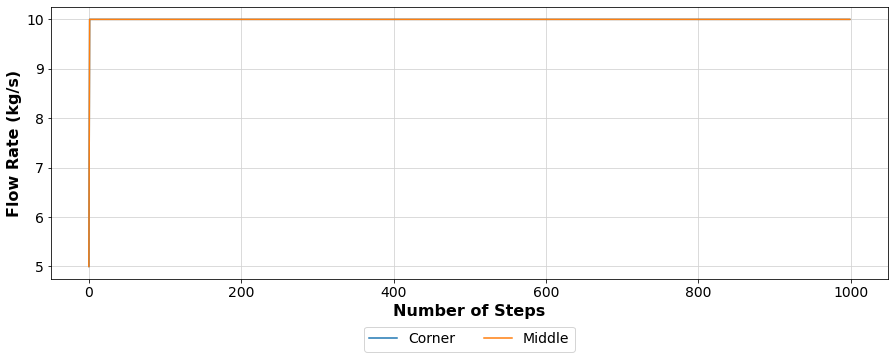

In [36]:
#Convergenge plot
a=Flowrate_Initial/NumberOfFractures
Flowrate_Frac1=np.insert(Flowrate_Frac1,0,a)
Flowrate_Frac5=np.insert(Flowrate_Frac5,0,a)
plt.figure(figsize = (15,5))
plt.plot(Flowrate_Frac1[0:MaxIterations])
plt.plot(Flowrate_Frac5[0:MaxIterations])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.autoscale() 
plt.legend(['Corner','Middle'],loc="upper center",ncol=5,bbox_to_anchor= (0.5, -0.15),prop={'size': 14},frameon=True)
plt.grid(which='major', axis='both',color='lightgrey',zorder=1)
plt.ylabel('Flow Rate (kg/s)', fontweight='bold',fontsize=16)
plt.xlabel('Number of Steps', fontweight='bold',fontsize=16)
plt.show()

[10.000000000000002, 10.000000000000002, 10.000000000000002, 10.000000000000002, 10.000000000000002, 10.000000000000002, 10.000000000000002, 10.000000000000002, 10.000000000000002, 10.000000000000002]


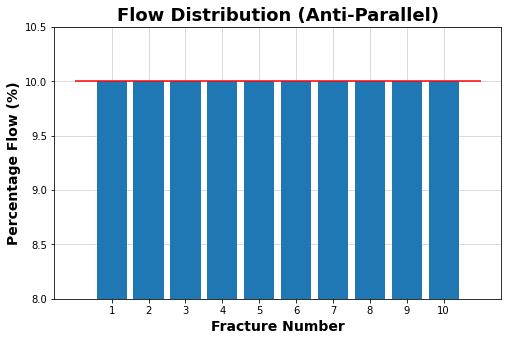

Friction Head= inf m
Del P= inf MPa
Del P= inf psi


In [40]:
#Flow Distribution
distpct=np.empty(NumberOfFractures)
temp=np.empty(NumberOfFractures)
plt.figure(figsize = (8,5))
# set width of bar
barWidth = 1*(NumberOfFractures-1)/(NumberOfFractures+1)

for i in range(NumberOfFractures):
    distpct[i]=100*(Flowrate_Fracture[i]/sum(Flowrate_Fracture))
x = np.linspace(1, NumberOfFractures, NumberOfFractures)
pmin=min(distpct)
pmax=max(distpct)
plt.ylim(ymin=pmin*0.8)
plt.ylim(ymax=pmax*1.05)
plt.hlines(100/NumberOfFractures, 0, NumberOfFractures+1, colors='r', linestyles='solid',zorder=3)              
plt.bar(x,distpct,width=barWidth,zorder=2)
# Add xticks on the middle of the group bars
plt.xticks(np.arange(1, NumberOfFractures+1, step=1))
plt.xlabel('Fracture Number', fontweight='bold',fontsize=14)
plt.ylabel('Percentage Flow (%)', fontweight='bold',fontsize=14)
if WellsOrientation==1:
    plt.title('Flow Distribution (Parallel)', fontweight='bold',fontsize=18)
elif WellsOrientation==2:
    plt.title('Flow Distribution (Anti-Parallel)', fontweight='bold',fontsize=18)
elif WellsOrientation==3:
    plt.title('Flow Distribution (Non-Parallel)', fontweight='bold',fontsize=18)
else:
    plt.title('\nFlow Distribution in Fractures', fontweight='bold',fontsize=18)
#plt.legend(loc="upper center",ncol=3,bbox_to_anchor= (0.5, -0.15),prop={'size': 12},frameon=True)
plt.grid(which='major', axis='both',color='lightgrey',zorder=1)
#$plt.savefig(r'%s/1.png', bbox_inches='tight')
print(list(distpct))
plt.show()
#pplots(Pi,n,"Inlet","yes")
#pplots(Po,n,"Outlet","yes")
print("Friction Head= "+str((max(Pressure_Injection)-min(Pressure_Production))/(9.8*1000))+" m")
print("Del P= "+str((max(Pressure_Injection)-min(Pressure_Production))/1e6)+" MPa")
print("Del P= "+str(145.038*(max(Pressure_Injection)-min(Pressure_Production))/1e6)+" psi")

## Reference
###Asai, P., Panja, P., Velasco, R., McLennan, J. and Moore, J., 2018. Fluid flow distribution in fractures for a doublet system in Enhanced Geothermal Systems (EGS). Geothermics, 75, pp.171-179.